In [36]:
import pandas as pd
from scipy.stats import kurtosis, skew
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import heartpy as hp
import numpy as np
from scipy.signal import find_peaks, resample
from scipy import integrate
from pathlib import Path
import os
from glob import glob
from biosppy.signals import ecg, ppg

palette = sns.color_palette()
z_score = lambda arr: (arr - arr.mean()) / arr.std()

In [2]:
FIGSIZE = (24, 4)
FIGSIZE_2 = (10, 4)

In [3]:
def load_csv(path, fs=64):
    df = pd.read_csv(path, names=['time', 'data'])
    df.index = np.arange(len(df)) / fs
    return df[['data']]

# **BaseSignal**

In [62]:
import inspect
from scipy.signal import savgol_filter, sosfiltfilt, butter, cheby2, firwin, filtfilt, iirnotch, freqz, welch, spectrogram, detrend
from scipy.fft import rfft, rfftfreq
from scipy.interpolate import interp1d
from statsmodels.tsa.seasonal import STL
from scipy.stats import skew, kurtosis

def create_new_obj(obj, **kwargs):
    init_args = list(inspect.signature(obj.__init__).parameters.items())
    args = {}
    for arg, val in init_args:
        if arg in kwargs.keys():
            args[arg] = kwargs[arg]
        else:
            if arg in vars(obj).keys():
                args[arg] = getattr(obj, arg)
            else:
                args[arg] = val.default
    return obj.__class__(**args)


def parse_nested_feats(nested_feats):
    feats_df = pd.json_normalize(nested_feats, sep='__')
    return feats_df.to_dict(orient='records')[0]


def get_outliers_mask(arr, IQR_scale):
    return (arr < np.mean(arr) + IQR_scale * np.std(arr)) & (arr > np.mean(arr) - IQR_scale * np.std(arr))


class BaseSignal:
    def __init__(self, name, data, fs, start_sec=0):
        self.name = name
        self.data = data
        self.fs = fs
        self.start_sec = start_sec
        self.n_samples = len(data)
        self.duration = self.n_samples / fs
        self.time = np.arange(0, self.n_samples) / fs
        self.peaks = None
        self.troughs = None
 
    def find_troughs(self):
        self.troughs, _ = find_peaks(-self.data)
        return self.troughs 
    
    def find_peaks(self):
        self.peaks, _ = find_peaks(self.data)
        return self.peaks
    
    def interpolate(self, fs, kind='cubic'):
        interp_fn = interp1d(self.time, self.data, kind=kind, fill_value='extrapolate')
        n_samples = int(self.n_samples * fs / self.fs)
        new_time = np.arange(0, n_samples) / fs
        new_time = new_time[(new_time >= self.time[0]) & (new_time <= self.time[-1])]
        interpolated = interp_fn(new_time)
        new_name = self.name + f"_interp({fs:.2f}Hz)"
        return create_new_obj(self, name=new_name, data=interpolated, fs=fs)
    
    def resample(self, n_samples):
        new_data = resample(self.data, n_samples)
        fs_scaler = len(new_data) / self.n_samples
        new_fs = self.fs * fs_scaler
        new_name = self.name + f"_resampled({n_samples})"
        return create_new_obj(self, name=new_name, data=new_data, fs=new_fs)
    
    def z_score(self):
        new_data = z_score(self.data)
        new_name = self.name + "_z_scored"
        return create_new_obj(self, name=new_name, data=new_data, fs=self.fs)
    
    def get_slice(self, start_time, end_time):
        mask = (self.time >= start_time) & (self.time <= end_time)
        new_name = self.name + f"_slice({start_time}-{end_time})"
        new_data = self.data[mask]
        return create_new_obj(self, name=new_name, data=new_data, fs=self.fs)
    
    def get_derivative(self, deriv=1, window_length=21, polyorder=5):
        new_name = self.name + f"_derivative({deriv})"
        new_data = savgol_filter(self.data, window_length, polyorder, deriv, delta = 1 / self.fs)
        return create_new_obj(self, name=new_name, data=new_data, fs=self.fs)
    
    def detrend(self):
        detrended = detrend(self.data)
        new_name = self.name + f"_detrended"
        return create_new_obj(self, name=new_name, data=detrended, fs=self.fs)
    
    def get_cheby2_filtered(self, cutoff, btype='lowpass', order=4, rs=10):
        sos = cheby2(order, rs, cutoff, btype, output='sos', fs=self.fs)
        filtered = sosfiltfilt(sos, self.data)
        new_name = self.name + f"_{btype}_cheby2_filt({np.round(cutoff, 2)})"
        return create_new_obj(self, name=new_name, data=filtered, fs=self.fs)
    
    def get_fir_filtered(self, cutoff, btype='lowpass', numtaps=10):
        firf = firwin(numtaps, cutoff, pass_zero=btype, fs=self.fs)
        filtered = filtfilt(firf, 1, self.data)       
        new_name = self.name + f"{btype}_fir_filt({np.round(cutoff, 2)})"
        return create_new_obj(self, name=new_name, data=filtered, fs=self.fs)
    
    def get_notch_filtered(self, cutoff, Q=10):
        b, a = iirnotch(cutoff, Q=Q, fs=self.fs)
        filtered = filtfilt(b, a, self.data)
        new_name = self.name + f"_notch_filt({np.round(cutoff, 2)})"
        return create_new_obj(self, name=new_name, data=filtered, fs=self.fs)
    
    def seasonal_decompose(self, plot=False):
        res = STL(self.data, period=self.fs).fit()
        if plot:
            res.plot()
        return res
    
    def fft(self, plot=False, ax=None):
        mags = rfft(self.data)
        freqs = rfftfreq(self.n_samples, 1 / self.fs)
        if plot:
            if ax is None:
                fig, ax = plt.subplots(figsize=(16, 8))
            ax.plot(freqs[1:], np.abs(mags[1:]))
        return freqs, mags
    
    def psd(self, window_size, min_hz=0, max_hz=10, use_bpm=True, plot=False, ax=None):
        freqs, pxx = welch(self.data, self.fs, nperseg=self.fs*window_size)
        if use_bpm:
            freqs, min_hz, max_hz = freqs * 60, min_hz * 60, max_hz * 60
            xlabel = 'Frequency [bpm]'
        else:
            xlabel = 'Frequency [Hz]'
        if plot:
            if ax is None:
                fig, ax = plt.subplots(figsize=(16, 8))
            mask = (freqs >= min_hz) & (freqs <= max_hz)
            
            ax.plot(freqs[mask], pxx[mask], lw=2)
            ax.set_xlabel(xlabel, fontsize=18) 
            ax.set_ylabel("Power Spectral Density", fontsize=18)
            ax.set_xlim([min_hz, max_hz])

        return freqs, pxx
    
    def spectrogram(self, NFFT=256, noverlap=128, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(20, 8))
        spectrum, freqs, t, img = ax.specgram(self.data, Fs=self.fs, NFFT=NFFT, noverlap=noverlap, cmap='viridis')
        cbar = plt.gcf().colorbar(img, ax=ax)
        cbar.ax.set_title('Intensity', fontsize=14)
        ax.set_ylabel('Frequency [Hz]', fontsize=18) 
        ax.set_xlabel('Time [s]', fontsize=18)  
        return spectrum, freqs, t
    
    def extract_basic_features(self):
        self.basic_features = {
            "mean" : np.mean(self.data),
            "std" : np.std(self.data),
            "median": np.median(self.data),
            "skewness": skew(self.data),
            "kurtosis": kurtosis(self.data),
        }
        return self.basic_features
    
    def extract_features(self):
        self.features = {
            'basic_features': self.extract_basic_features()
        }
        return self.features
    
    def plot(self, start_time=0, width=None, scatter=False, extrema=True, line=True, first_der=False, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(18, 6))
        if width is None:
            width = self.time[-1] - start_time
        end_time = start_time + width
        if start_time == 0 and self.duration < width:
            signal_slice = self # no need to slice
        else:
            signal_slice = self.get_slice(start_time, end_time)
        if scatter:
            sig_plot = ax.scatter(signal_slice.time, signal_slice.data, lw=3, label=signal_slice.name)
            plots = [sig_plot]
        if line:
            sig_plot = ax.plot(signal_slice.time, signal_slice.data, lw=3, label=signal_slice.name)
            plots = [sig_plot[0]]
        if first_der:
            ax2 = ax.twinx()
            signal_slice_der = signal_slice.get_derivative()
            first_der_plot = ax2.plot(signal_slice_der.time, signal_slice_der.data, c=sns.color_palette()[1], lw=1, label=signal_slice_der.name)
            plots.append(first_der_plot[0])
            ax2.set_ylabel("First derivative values", fontsize=18)
            ax2.axhline(y = 0, c='black', ls='--', lw=0.5)
        if extrema:
            if self.peaks is None or self.troughs is None:
                self.find_peaks()
                self.find_troughs()
            ax.scatter(self.time[self.troughs], self.data[self.troughs], c='r', s=150, marker='v', label='troughs')
            ax.scatter(self.time[self.peaks], self.data[self.peaks], c='g', s=150, marker='^', label='peaks')
            
        labels = [plot.get_label() for plot in plots]
        ax.legend(plots, labels, loc=0, fontsize=18)
        ax.set_ylabel("values", fontsize=18)
        ax.set_xlabel("Time [s]", fontsize=18)
        ax.set_title(self.name, fontsize=22)
       
    def explore(self, start_time, width=None, window_size=4, min_hz=0, max_hz=10):
        if width is None:
            width = self.time[-1] - start_time
            
        signal_slice = self.get_slice(start_time, start_time+width)
        fig = plt.figure(figsize=(40, 20), constrained_layout=True)
        spec = fig.add_gridspec(8, 8, hspace=.8, wspace=.8)

        ax00 = fig.add_subplot(spec[:4, :6])
        ax01 = fig.add_subplot(spec[:4, 6:])
        ax11 = fig.add_subplot(spec[4:, :4])
        ax12 = fig.add_subplot(spec[4:, 4:])

        signal_slice.plot(start_time, width, ax=ax00)
        sns.kdeplot(signal_slice.data, ax=ax01, lw=3)
        signal_slice.psd(window_size=window_size, min_hz=min_hz, max_hz=max_hz, plot=True, ax=ax11)
        signal_slice.spectrogram(ax=ax12)
        
        axes_params = [
            (ax00, "Signal"),
            (ax01, "Kernel Density Estimation"), 
            (ax11, "Power Spectral Density"), 
            (ax12, "Spectrogram")
        ]   
        
        for ax, title in axes_params:
            ax.set_title(title, fontsize=26,fontweight="bold")
            ax.tick_params(axis='both', which='major', labelsize=18)

# **PeriodicSignal (`abstract`)**

In [63]:
from abc import ABC, abstractmethod
import numpy as np 

class PeriodicSignal(ABC, BaseSignal):
    def __init__(self, name, data, fs, start_sec=0):
        super().__init__(name, data, fs, start_sec)
        self.beats = None # List of PPGBeat objects
        self.valid_beats_mask = None
        self.agg_beat = None # PPGBeat object
        self.agg_beat_features = None
       
    @abstractmethod
    def get_beats(self, resample_beats=True, n_samples=100, validate=True, plot=False):
        pass
    
    def plot_beats(self, same_ax=True, ax=None, plot_valid=True, plot_invalid=True):
        if self.beats is None:
            self.get_beats()
        beats_to_plot = [beat for beat in self.beats if (beat.is_valid and plot_valid) or (not beat.is_valid and plot_invalid)]
        n_beats = len(beats_to_plot)
        n_valid = np.sum([beat.is_valid for beat in beats_to_plot])
        n_invalid = n_beats - n_valid
        valid_palette = sns.color_palette("Greens", n_colors=n_beats)
        invalid_palette = sns.color_palette("Reds", n_colors=n_beats)
        if same_ax:  
            if ax is None:
                fig, ax = plt.subplots(figsize=FIGSIZE_2)
            for i, beat in enumerate(beats_to_plot):
                palette = valid_palette if beat.is_valid else invalid_palette
                ax.plot(beat.time, beat.data, color=palette[i])
            ax.plot(self.agg_beat.time, self.agg_beat.data, lw=8, alpha=0.5, c='black', label='Aggregated beat')
            ax.set_title(f"{n_beats} beats ({n_valid} valid, {n_invalid} invalid)", fontsize=22)
            ax.legend()
        else:
            ncols = 5
            nrows = int(np.ceil(n_beats / ncols))
            
            fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
            for beat, ax in zip(beats_to_plot, axes.flatten()):
                palette = valid_palette if beat.is_valid else invalid_palette
                ax.plot(beat.time, beat.data, lw=3, c=palette[int(n_beats / 1.5)])
                ax.set_title(beat.name, fontsize=18)
            plt.tight_layout()
        
    def aggregate(self, valid_only=True, **kwargs):
        # agreguje listę uderzeń w pojedyncze uderzenie sPPG i je zwraca (jako obiekt PPGBeat)
        if self.beats is None:
            self.get_beats(**kwargs)
        beats_to_aggregate_mask = self.valid_beats_mask if valid_only else len(self.beats) * [True]
        beats_to_aggregate = self.beats[beats_to_aggregate_mask]
        beats_data = np.array([beat.data for beat in beats_to_aggregate])
        beats_times = np.array([beat.time for beat in beats_to_aggregate])
        agg_beat_data, agg_beat_time = beats_data.mean(axis=0), beats_times.mean(axis=0)
        agg_fs = len(agg_beat_data) / (agg_beat_time[-1] - agg_beat_time[0])
        BeatClass = beats_to_aggregate[0].__class__
        agg_beat = BeatClass("agg_beat", agg_beat_data, agg_fs, start_sec=0)
        self.agg_beat = agg_beat
        return self.agg_beat
    
    def explore(self, start_time=0, width=None, window_size=4, min_hz=0, max_hz=10):
        super().explore(start_time, width, window_size, min_hz, max_hz)
        self.get_beats(plot=True)
        self.agg_beat.explore(start_time=0)

# **BeatSignal (`abstract`)**

In [64]:
class BeatSignal(ABC, BaseSignal):
    def __init__(self, name, data, fs, start_sec, beat_num=0, is_valid=True):
        super().__init__(name, data, fs, start_sec)
        self.is_valid = is_valid
        self.beat_num = beat_num
        
    @abstractmethod
    def extract_agg_beat_features(self, plot=True):
        pass
    
    def explore(self, start_time=0, width=None, window_size=4, min_hz=0, max_hz=10):
        self.extract_agg_beat_features(plot=True)

# **PPGSignal and PPGBeat**

In [71]:
from scipy.signal import butter, filtfilt


def get_no_outlier_beats_mask(beats, IQR_scale = 1.5):
    beats_data = np.array([beat.data for beat in beats])
    beats_times = np.array([beat.time for beat in beats])
        
    mean_beats = beats_data.mean(axis=1)
    beats_durations = np.array([t[-1] - t[0] for t in beats_times])
    min_vals = np.array([v.min() for v in beats_data])
    max_vals = np.array([v.max() for v in beats_data])
    
    data_mask = get_outliers_mask(mean_beats, IQR_scale=IQR_scale)
    duration_mask = get_outliers_mask(beats_durations, IQR_scale=IQR_scale)
    min_vals_mask = get_outliers_mask(min_vals, IQR_scale=IQR_scale)
    max_vals_mask = get_outliers_mask(max_vals, IQR_scale=IQR_scale)

    valid_beats_mask = data_mask & duration_mask & min_vals_mask & max_vals_mask
    return valid_beats_mask


def get_valid_beats_mask(beats, max_duration=1.1):
    duration_mask = np.array([beat.duration <= max_duration for beat in beats])
    no_outlier_beats_mask = get_no_outlier_beats_mask(beats)
    return duration_mask & no_outlier_beats_mask


def moving_average(data, winsize):
    extended_data = np.concatenate((
        np.ones(winsize) * data[0],
        data,
        np.ones(winsize) * data[-1]
    ))
    win = np.ones(winsize) / winsize
    smoothed = np.convolve(extended_data, win, mode='same')
    return smoothed[winsize:-winsize]


def find_systolic_peaks_ELGENDI(data, fs, f1=0.5, f2=8, w1=0.111, w2=0.667, beta=0.2):
    """
    Ref: https://pubmed.ncbi.nlm.nih.gov/24167546/
    """
    cutoff = [f1, f2]
    cutoff = 2.0 * np.array(cutoff) / fs
    b, a = butter(N=2, Wn=cutoff, btype='bandpass', analog=False, output="ba")
    filtered = filtfilt(b, a, data)                   # 2
    clipped = np.copy(filtered)                       # 3
    clipped[clipped < 0] = 0  
    squared = clipped ** 2                            # 4

    ma_peak = moving_average(squared, int(w1 * fs))   # 5
    ma_beat = moving_average(squared, int(w2 * fs))   # 6

    z_mean = squared.mean()                           # 7
    alpha = beta * z_mean                             # 8

    thr_1 = ma_beat + alpha                           # 9

                                                      #  10 - 16
    valid_segments = ma_peak > thr_1
    starts = np.where(~valid_segments[0:-1] & valid_segments[1:])[0] 
    ends = np.where(valid_segments[0:-1] & ~valid_segments[1:])[0]
    ends = ends[ends > starts[0]]

    blocks = zip(starts, ends)                       # 17
    thr_2 = w1                                       # 18

    peaks = []
                                                     #  19 - 25
    for start, end in blocks:
        if end - start >= thr_2:
            peaks.append(data[start:end].argmax() + start)
    return np.array(peaks)



class PPGSignal(PeriodicSignal):
    def __init__(self, name, data, fs, start_sec=0):
        super().__init__(name, data, fs, start_sec)
        self.hrv_features = None
        
    def find_troughs(self):
        data_z_score = z_score(self.data)
        troughs, _ = find_peaks(-data_z_score, height=0.5)
        self.troughs = troughs
        return troughs
    
    def find_peaks(self):
        peaks_idxs = find_systolic_peaks_ELGENDI(self.data, self.fs)
        self.peaks = peaks_idxs
        return self.peaks
                 
        
    def get_beats(self, resample_beats=True, n_samples=100, validate=True, plot=False):
        if self.peaks is None:
            self.find_peaks()
        if self.troughs is None:
            self.find_troughs()
            
        peaks_time = self.time[self.peaks]
        peaks_values = self.data[self.peaks]            
        
        beats = []
        for i, (trough_start, trough_end) in enumerate(zip(self.troughs[:-1], self.troughs[1:])):
            peaks_between = self.peaks[(self.peaks > trough_start) & (self.peaks < trough_end)]
            if len(peaks_between) == 0:
                continue
            beat_data = self.data[trough_start: trough_end]
            beat_time = self.time[trough_start: trough_end] - self.time[trough_start] # removing first time value to get proper beat timing
            beat = PPGBeat(f"beat_{i}", beat_data, fs=self.fs, start_sec=self.time[trough_start], beat_num=len(beats))
            if resample_beats:
                beat = beat.resample(n_samples)
            beats.append(beat)
        
        self.beats = np.array(beats, dtype=PPGBeat)
        self.valid_beats_mask = get_valid_beats_mask(self.beats)
        for beat, is_valid in zip(self.beats, self.valid_beats_mask):
            beat.is_valid = is_valid
        
        if plot:
            # self.plot(extrema=True)
            fig, axes = plt.subplots(1, 2, figsize=(24, 5))
            self.aggregate(valid_only=False)
            self.plot_beats(plot_valid=True, plot_invalid=True, ax=axes[0])
            self.aggregate(valid_only=True)
            self.plot_beats(plot_valid=True, plot_invalid=False, ax=axes[1])
        else:
            self.aggregate(valid_only=True)
            
        return self.beats

    def extract_hrv_features(self):
        if self.hrv_features is None:
            self.find_peaks() # hrv_features are calculated there
        return self.hrv_features
      
    def extract_features(self, plot=True, parse=True):
        # rozwinięcie cech podstawowej klasy Signal o cechy typowe dla sygnału PPG (do wyczytania z artykułów)
        if self.agg_beat is None:
            self.get_beats(plot=plot)
        self.features = super().extract_features()
        ppg_features = {
            'agg_beat_features': self.agg_beat.extract_features(plot=plot),
            'hrv_features': self.extract_hrv_features()
        }
        self.features.update(ppg_features)
        features = parse_nested_feats(self.features) if parse else self.features
        features = {f"{self.name}__{feat_name}": feat_val for feat_name, feat_val in features.items()}
        return features
    
    def explore(self, start_time=0, width=None, window_size=4, min_hz=0, max_hz=10):
        super().explore(start_time, width, window_size, min_hz, max_hz)
    
    
class PPGBeat(BeatSignal):
    def __init__(self, name, data, fs, start_sec, beat_num=0):
        super().__init__(name, data, fs, start_sec, beat_num)
        self.find_systolic_peak()
             
    def find_systolic_peak(self):
        # metoda znajdująca pik systolic (algorytm do znalezienia w artykułach)
        self.systolic_peak_loc = self.data.argmax() # XD
        self.systolic_peak_time = self.time[self.systolic_peak_loc]
        self.systolic_peak_val = self.data[self.systolic_peak_loc]
    
    def find_dicrotic_notch(self):
        # metoda znajdująca dołek dicrotic (algorytm do znalezienia w artykułach)
        pass
    
    def find_diastolic_peak(self):
        # metoda znajdująca pik diastolic (algorytm do znalezienia w artykułach)
        pass
            
    def extract_agg_beat_features(self, plot=True):
        systolic_onset_slope = (self.systolic_peak_val - self.data[0]) / self.systolic_peak_time
        systolic_offset_slope = (self.systolic_peak_val - self.data[-1]) / (self.duration - self.systolic_peak_time)
        energy = (self.data ** 2).mean()
        before_systolic_area = integrate.simpson(abs(self.data[:self.systolic_peak_loc]), self.time[:self.systolic_peak_loc])
        after_systolic_area = integrate.simpson(abs(self.data[self.systolic_peak_loc:]), self.time[self.systolic_peak_loc:])
        
        if plot:
            fig, ax = plt.subplots(figsize=FIGSIZE_2)
            ax.plot(self.time, self.data, c=sns.color_palette()[0], lw=3)
            ax.scatter(self.time[self.systolic_peak_loc], self.data[self.systolic_peak_loc], s=200, c='r', marker='^', label='systolic peak')
            ax.fill_between(self.time, self.data, self.data.min(), where = self.time <= self.time[self.systolic_peak_loc], color = 'g', alpha=0.2)
            ax.fill_between(self.time, self.data, self.data.min(), where = self.time >= self.time[self.systolic_peak_loc], color = 'r', alpha=0.2)
#             area_1_txt_loc = self.systolic_peak_time - self.systolic_peak_time / 2, 0.33
#             area_2_txt_loc = self.systolic_peak_time + self.systolic_peak_time / 2, 0.33
            
#             ax.text(area_1_txt_loc[0], area_1_txt_loc[1], 'pole powierz przed sys_peak', props, rotation=45)
            ax.set_title(f"Pojedyncze uderzenie PPG", fontsize=24)
            ax.set_xlabel("Czas [s]", fontsize=20)
            ax.set_ylabel("j.u.", fontsize=20)
            ax.legend()
            fig.savefig("sppg.png", dpi=500)
        
        self.agg_beat_features = {
            'duration': self.duration,
            'systolic_peak_val': self.systolic_peak_val,
            'systolic_peak_time': self.systolic_peak_time,
            'systolic_onset_slope': systolic_onset_slope,
            'systolic_offset_slope': systolic_offset_slope,
            'energy': energy,
            'before_systolic_area': before_systolic_area,
            'after_systolic_area': after_systolic_area
            
        }
        return self.agg_beat_features
            
    def extract_features(self, plot=True):
        # rozwinięcie cech podstawowej klasy Signal o cechy typowe dla zagregowanego sygnału PPG, czyli sPPG (do wyczytania z artykułów)
        self.features = super().extract_features()
        sppg_features = self.extract_agg_beat_features(plot=plot)
        self.features.update(sppg_features) 
        return self.features
    
    def explore(self, start_time=0, width=None, window_size=4, min_hz=0, max_hz=10):
        super().explore(start_time, width, window_size, min_hz, max_hz)

# **ECGSignal and ECGBeat**

In [72]:
class ECGSignal(PeriodicSignal):
    def __init__(self, name, data, fs, start_sec=0):
        super().__init__(name, data, fs, start_sec)
        self.hrv_features = None
    
    def get_beats(self):
        pass
    
    
class ECGBeat(BeatSignal):
    def __init__():
        pass

In [10]:
DB_PATH = Path("data/patient_data_raw_night_sessions_trimmed")
subjects = [3, 6, 7, 8, 9, 10, 11]

In [1201]:
def get_session_paths(subjects):
    subject_paths = {subject: [] for subject in subjects}
    for subject in subjects:
        session_paths = glob(str(DB_PATH / f"p{subject}/*/"), recursive=True)
        session_paths = [Path(path) for path in session_paths if ".csv" not in path]
        for session_path in session_paths:
            filenames = glob(f"{session_path}/*", recursive=True)
            all_sigs_available = all([str(session_path / f"{sig_name}.csv") in filenames for sig_name in ["bvp", "cgm"]])
            if all_sigs_available:
                subject_paths[subject].append(session_path)
    return subject_paths

subjects_session_paths = get_session_paths(subjects)
good_session_path = Path('data/patient_data_raw_night_sessions_trimmed/p8/2')

In [22]:
mimic_ecg_signal =  ECGSignal("mimic PPG", pd.read_csv("data/sample/mimic_2.csv").ECG.values, fs=125)
mimic_ppg_signal = PPGSignal("mimic PPG", pd.read_csv("data/sample/mimic_2.csv").PPG.values, fs=125)
# mimic_ppg_signal.plot_beats(same_ax=True, plot_valid=True, plot_invalid=True)

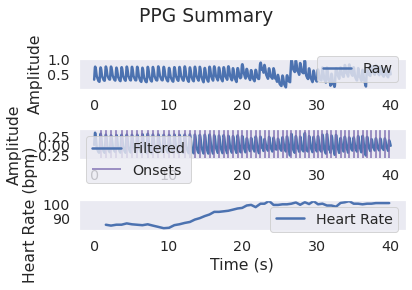

In [1332]:
r = ppg.ppg(mimic_ppg_signal.get_slice(0, 40).data, 125)

In [ ]:
mimic_ppg_signal.get_slice(0, 40)

IndexError: index 2573 is out of bounds for axis 0 with size 2501

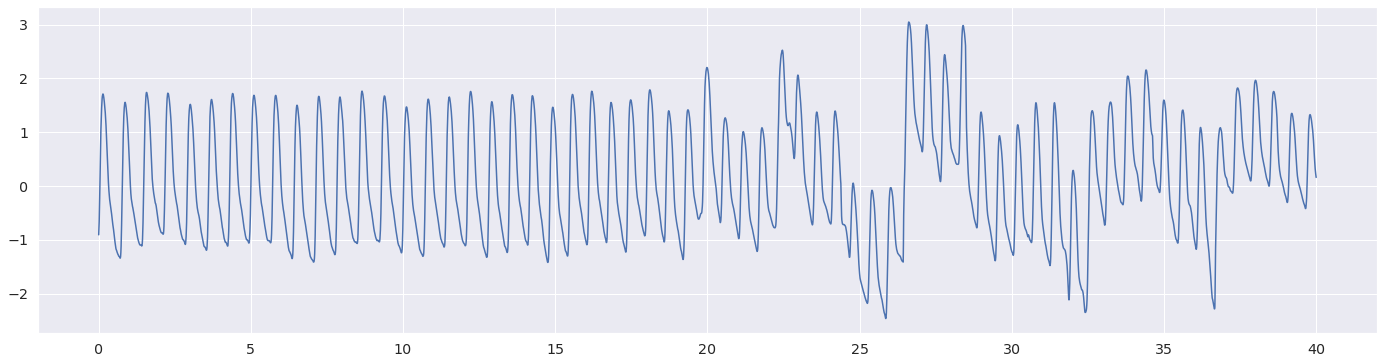

In [1337]:
plt.figure(figsize=(24, 6))
plt.plot(mimic_ppg_signal.z_score().get_slice(0, 40).time, mimic_ppg_signal.z_score().get_slice(0, 40).data)
plt.scatter(mimic_ppg_signal.z_score().get_slice(0, 40).time[p], filtered[p])

In [1336]:
p = r['onsets']

In [1334]:
mimic_ppg_signal.get_slice(0, 40).find_peaks()

array([  16,  109,  197,  285,  376,  463,  550,  638,  727,  815,  904,
        991, 1082, 1174, 1264, 1353, 1440, 1528, 1615, 1699, 1782, 1865,
       1946, 2026, 2105, 2185, 2264, 2342, 2420, 2497, 2574, 2648, 2724,
       2806, 2872, 2950, 3026, 3100, 3177, 3251, 3327, 3401, 3475, 3552,
       3625, 3700, 3775, 3850, 3926, 4002, 4079, 4154, 4227, 4302, 4376,
       4452, 4526, 4604, 4676, 4751, 4826, 4900, 4977])

/home/shate/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


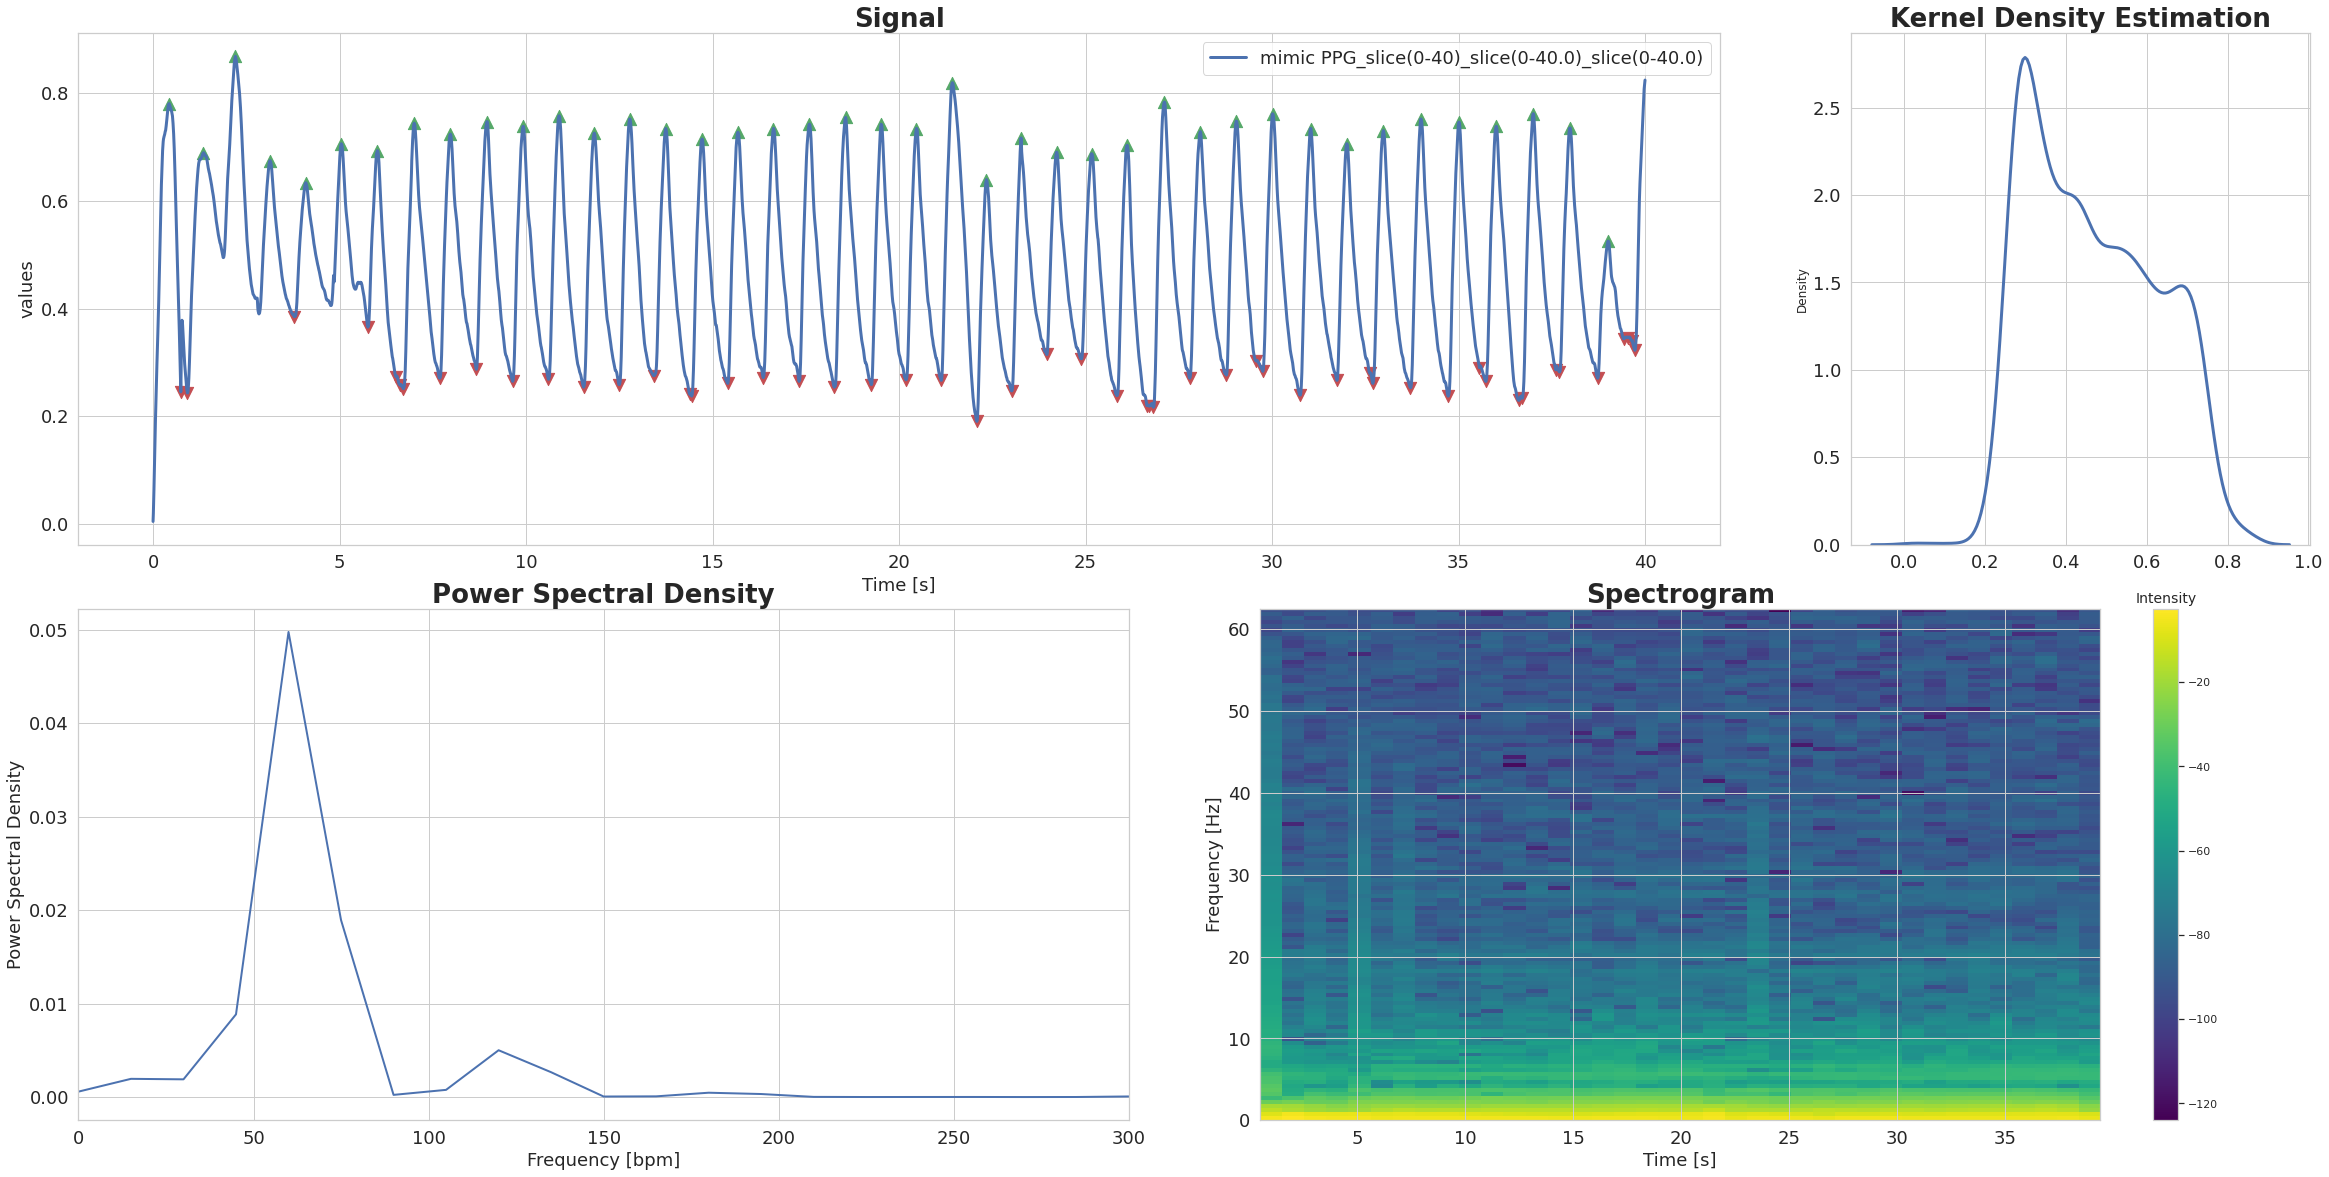

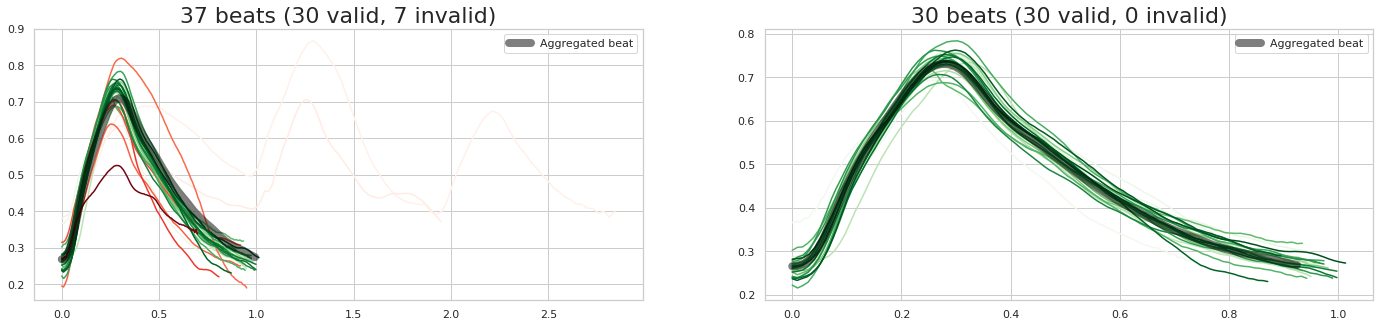

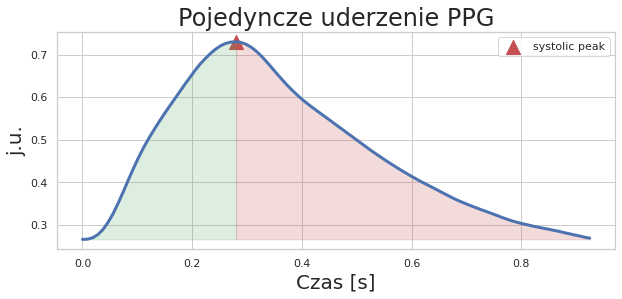

In [75]:
sns.set(style='whitegrid')
mimic_ppg_signal.get_slice(0, 40).explore(max_hz=5)

In [68]:
info = pd.read_csv("mimic/mimic_info/dataset_info_120s.csv")
sample_path = info['sample_path'].values[0]

In [73]:
df = pd.read_csv(f"mimic/mimic_csv_120s/{sample_path}")
mimic_ecg_signal =  ECGSignal("mimic PPG", df.ECG.values, fs=125)
mimic_ppg_signal = PPGSignal("mimic PPG", df.PPG.values, fs=125)

In [28]:
data = mimic_ppg_signal.get_slice(0, 50).data
time = mimic_ppg_signal.get_slice(0, 50).time

In [29]:
my_peaks = find_systolic_peaks_ELGENDI(data, fs=125)
bio_peaks = ppg.ppg(data, 125, False)['onsets']

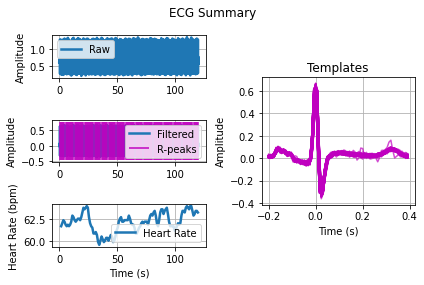

In [23]:
out = ecg.ecg(signal=mimic_ecg_signal.data, sampling_rate=125., show=True)

/home/shate/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


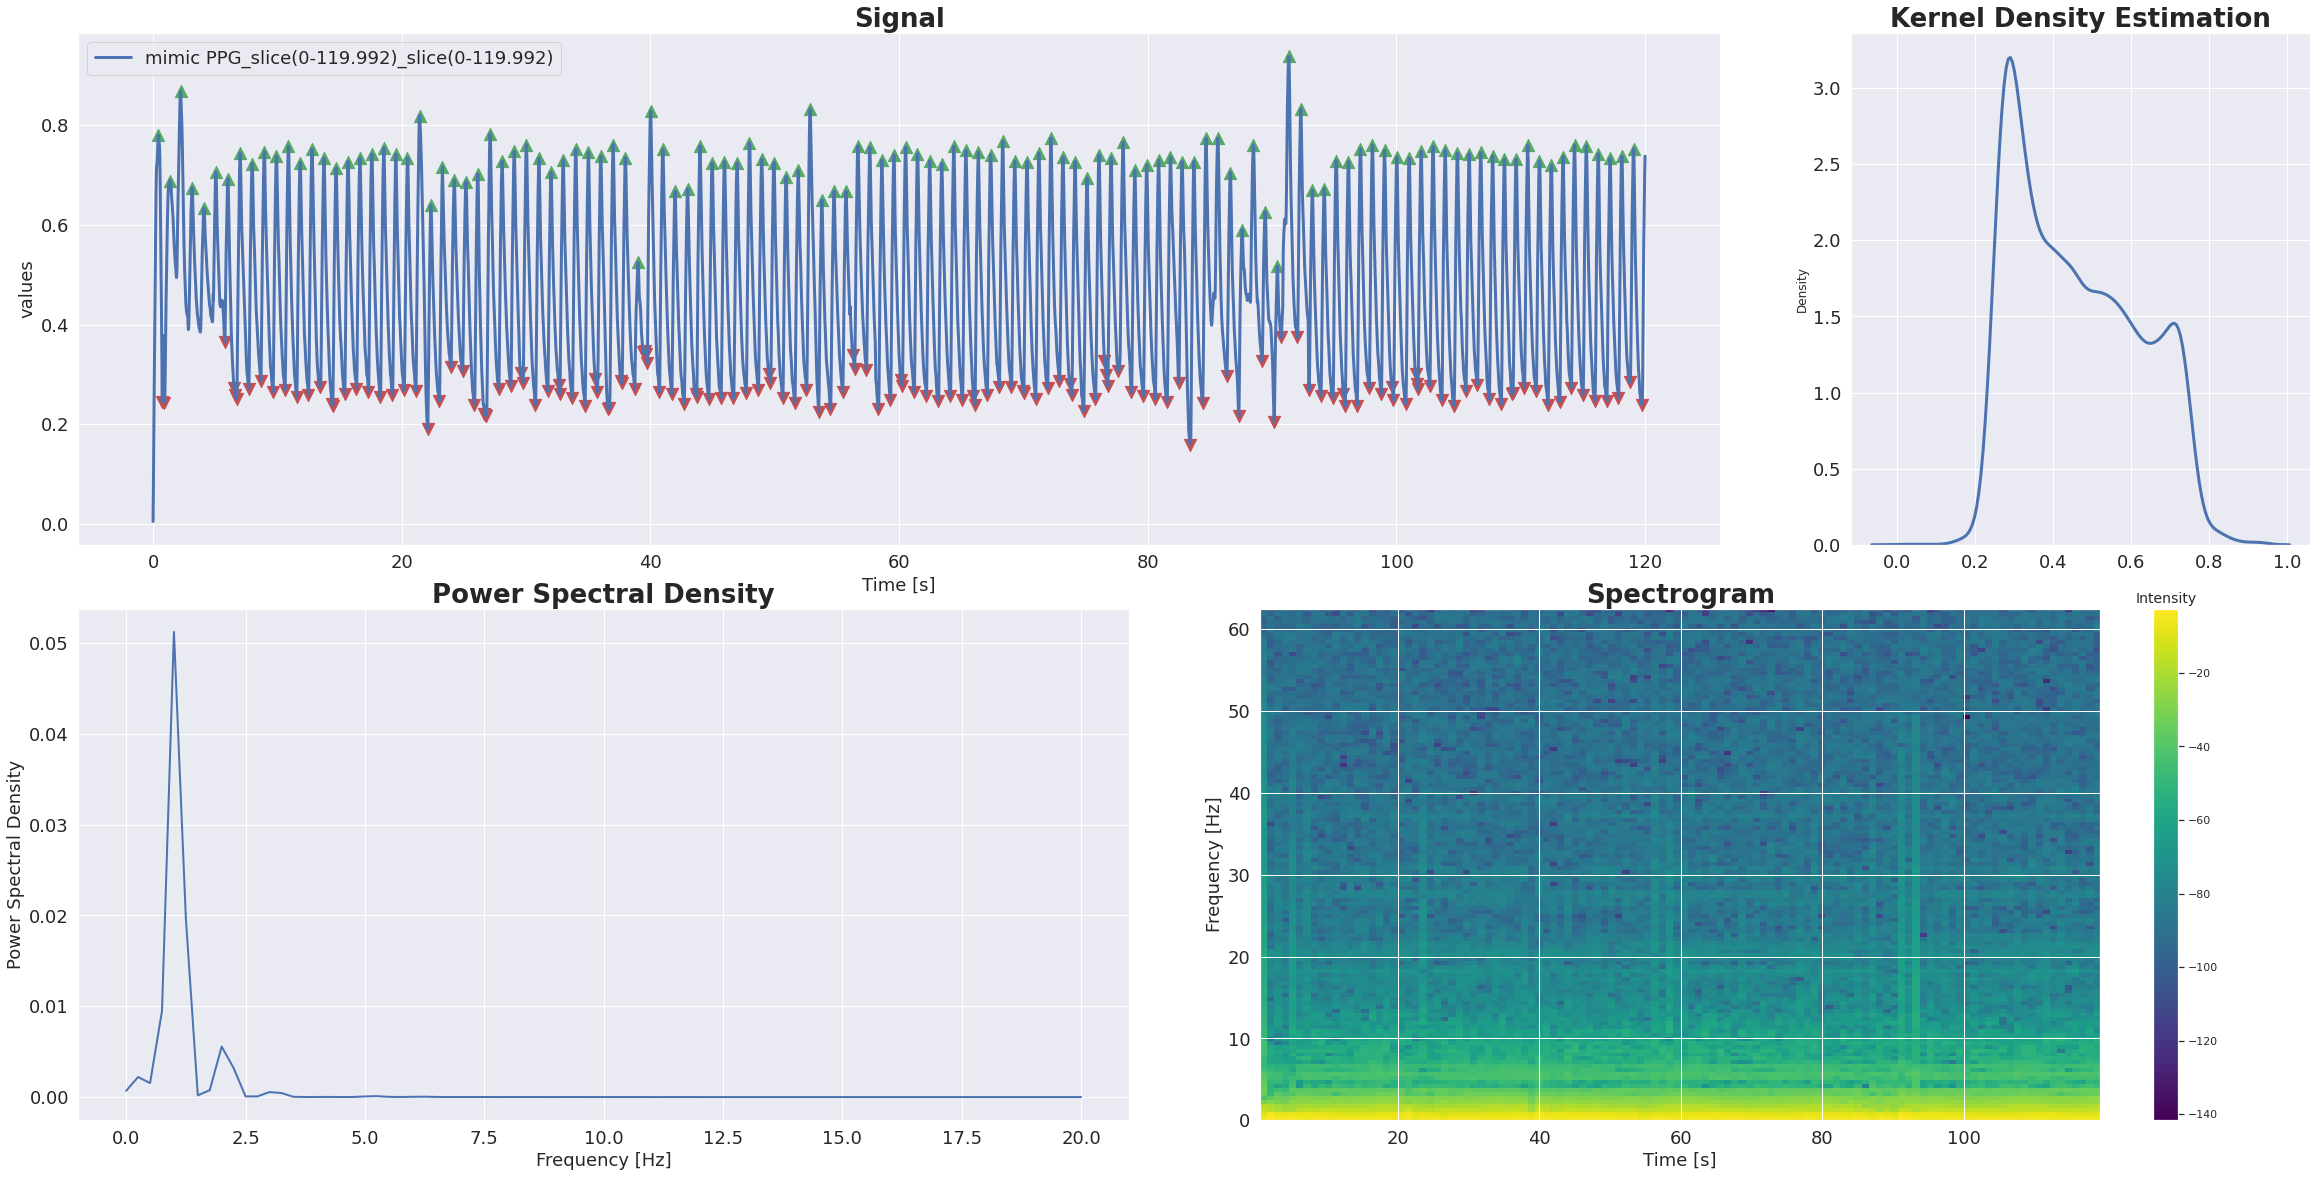

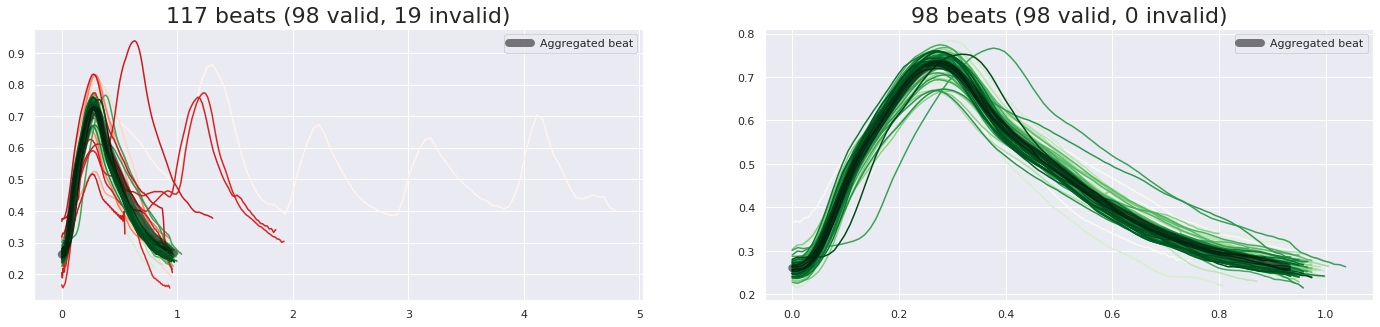

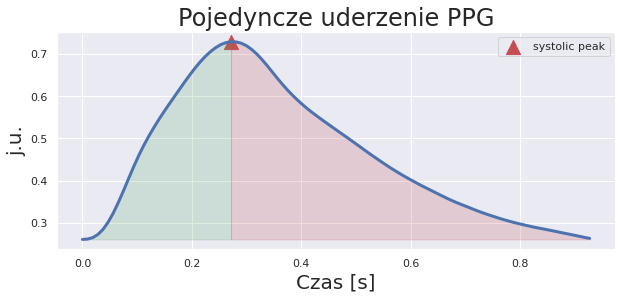

In [37]:
mimic_ppg_signal.explore()

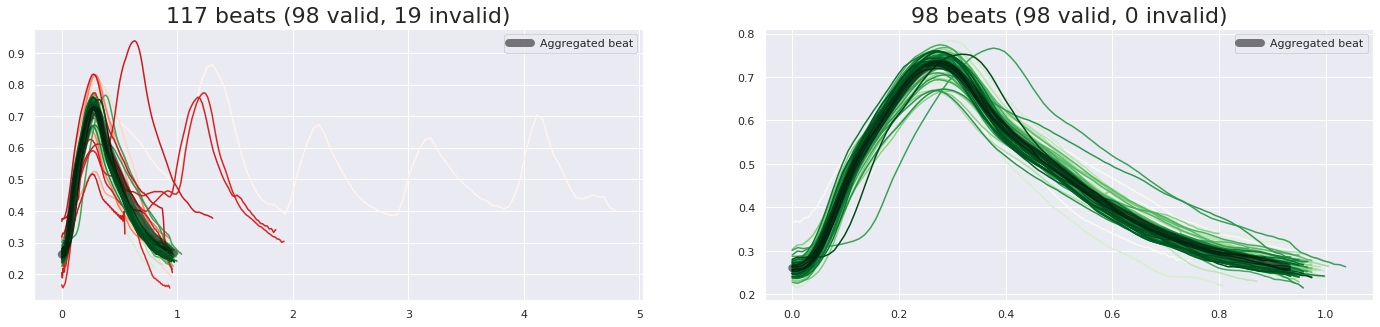

In [35]:
beats = mimic_ppg_signal.get_beats(plot=True)

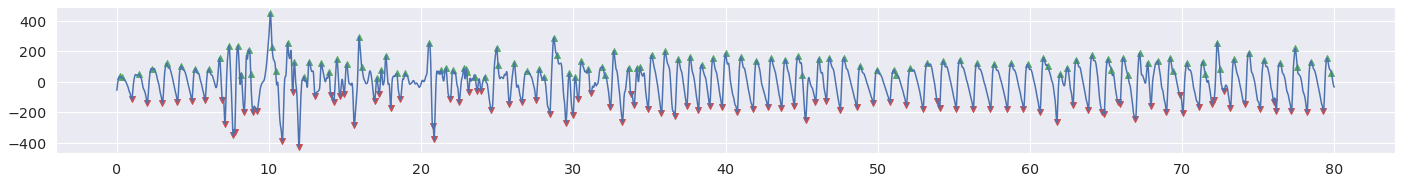

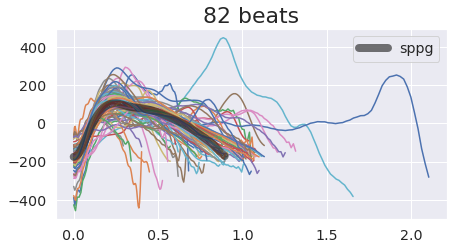

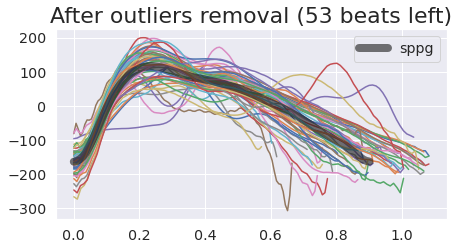

In [626]:
beats = ppg_signal.get_slice(220, 300).get_beats(plot=True)

{'PPG__basic_features__mean': -0.2803319016009372,
 'PPG__basic_features__std': 55.34606891765654,
 'PPG__basic_features__median': 5.92,
 'PPG__basic_features__skewness': -0.18560499588597887,
 'PPG__basic_features__kurtosis': 0.6798072256115737,
 'PPG__sppg_features__basic_features__mean': 0.2849396169832775,
 'PPG__sppg_features__basic_features__std': 37.55330197956952,
 'PPG__sppg_features__basic_features__median': 14.345443022493921,
 'PPG__sppg_features__basic_features__skewness': -0.5963418621805264,
 'PPG__sppg_features__basic_features__kurtosis': -0.9866831117054522,
 'PPG__sppg_features__duration': 0.6806249999999998,
 'PPG__sppg_features__systolic_peak_val': 46.00329258773793,
 'PPG__sppg_features__systolic_peak_time': 0.19738124999999995,
 'PPG__sppg_features__systolic_onset_slope': 604.8045413205243,
 'PPG__sppg_features__systolic_offset_slope': 244.8668234639594,
 'PPG__sppg_features__energy': 1410.3316801540661,
 'PPG__sppg_features__before_systolic_area': 7.2383108116735

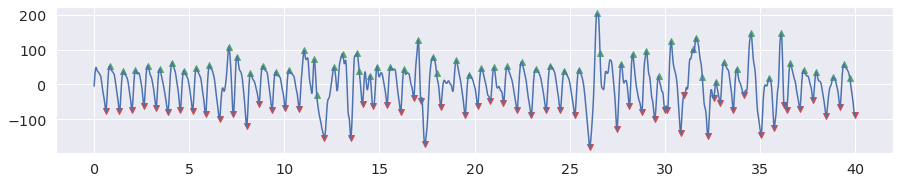

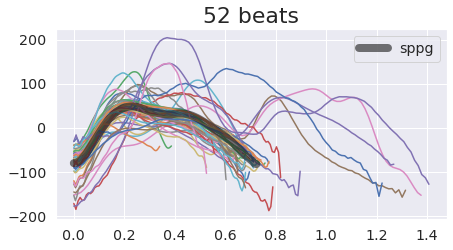

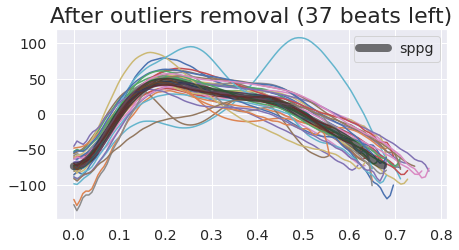

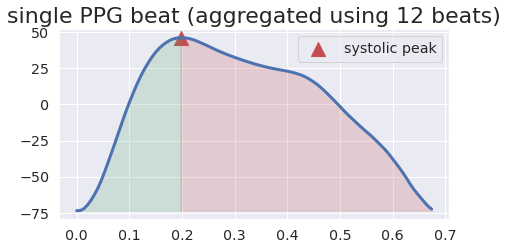

In [551]:
ppg_signal.extract_features(plot=True)

/tmp/ipykernel_219625/3967655717.py:128: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.gcf().colorbar(img, ax=ax)
/home/shate/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


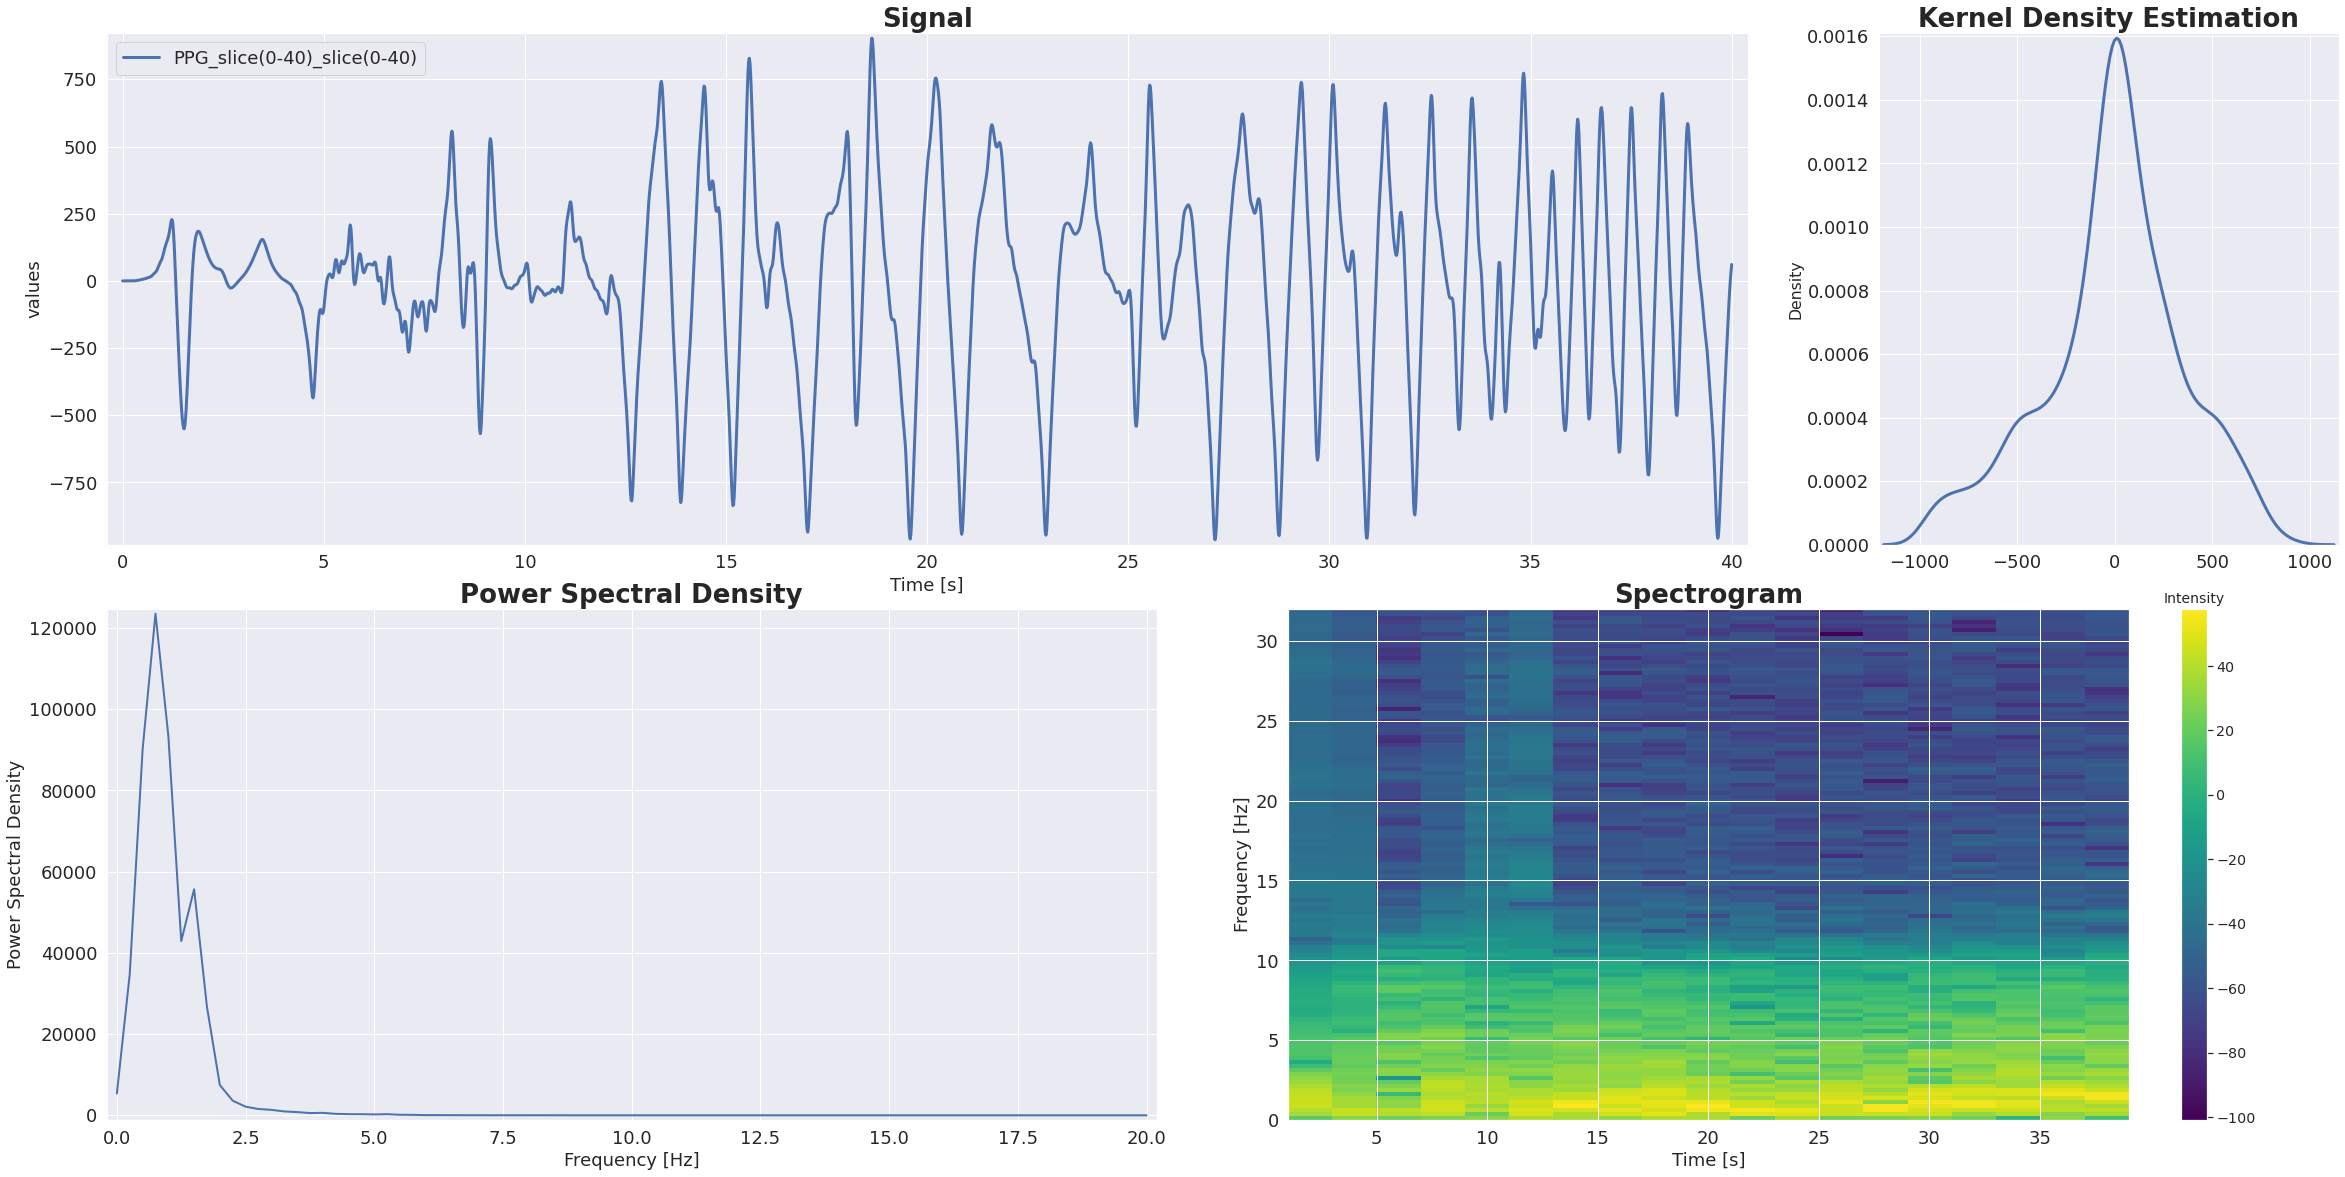

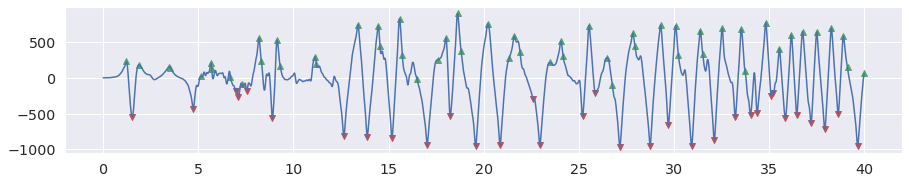

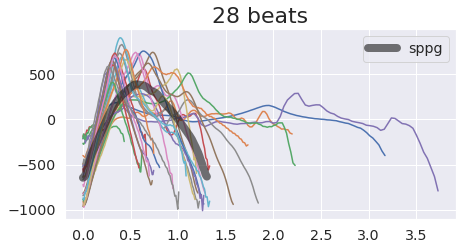

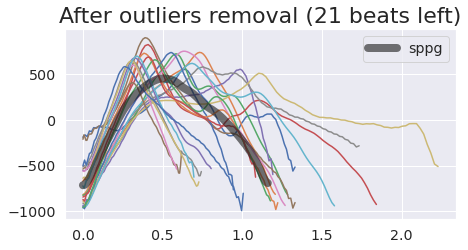

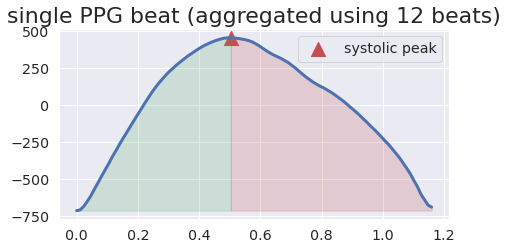

In [475]:
ppg_signal.explore(0, 40)

# **Creating dataset**

In [500]:
pths = {7: subjects_session_paths[7]}

In [1371]:
pd.read_csv("dataset.csv")

,basic_features__mean,basic_features__std,basic_features__median,basic_features__skewness,basic_features__kurtosis,sppg_features__basic_features__mean,sppg_features__basic_features__std,sppg_features__basic_features__median,sppg_features__basic_features__skewness,sppg_features__basic_features__kurtosis,...,hrv_features__pnn50,hrv_features__hr_mad,hrv_features__sd1,hrv_features__sd2,hrv_features__s,hrv_features__sd1/sd2,hrv_features__breathingrate,glucose,subject,session
0,-0.098761,193.494495,-0.465,-0.249569,7.242100,14.600728,109.591348,59.025227,-0.973423,-0.285388,...,1.000000,125.0000,189.892148,164.431628,98093.953187,1.154840,0.200000,158,p3,0
1,0.106778,228.158384,9.190,-0.850826,7.016073,-4.446123,119.998399,50.450581,-1.137729,0.065765,...,1.000000,156.2500,49.684333,101.662611,15868.307191,0.488718,0.211372,155,p3,0
2,-0.107284,177.073268,1.630,-0.010957,5.123544,4.672404,95.482792,40.257189,-0.902114,-0.448603,...,0.803571,148.4375,165.470528,175.507333,91235.906856,0.942813,0.233333,90,p3,1
3,0.111732,125.621057,1.940,-0.555034,14.054345,10.422230,80.115951,37.377940,-0.786921,-0.634722,...,0.800000,140.6250,86.433229,176.969939,48054.063020,0.488406,0.170155,90,p3,1
4,0.056658,152.041495,3.245,0.016815,5.750669,11.442149,82.939784,46.825164,-1.033330,-0.206115,...,0.736842,156.2500,159.681653,163.432836,81986.851467,0.977048,0.166667,90,p3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840,0.019113,57.007454,16.120,-0.496511,-0.919453,-0.072198,55.528368,17.805754,-0.556386,-1.080141,...,0.435424,46.8750,65.873524,102.901332,21295.202051,0.640162,0.233333,139,p11,9
3841,0.046006,53.893238,15.770,-0.502528,-0.911534,0.137207,52.218194,17.820047,-0.554828,-1.091392,...,0.434028,46.8750,62.677661,94.253874,18559.311429,0.664988,0.233333,138,p11,9
3842,-0.006581,71.615638,12.960,-0.050002,9.375893,0.286087,50.479681,16.153578,-0.525368,-1.082017,...,0.350877,78.1250,56.999090,168.597783,30190.454953,0.338077,0.133333,149,p11,9
3843,0.000848,51.054998,15.230,-0.516901,-0.849514,0.078888,49.704485,18.091730,-0.565019,-1.083518,...,0.349823,46.8750,52.917627,83.495408,13880.746392,0.633779,0.166667,164,p11,9


In [502]:
from tqdm.notebook import tqdm

fs_multiplier = 300 * 64

dataset_rows = []
    
for subject, session_paths in tqdm(pths.items(), desc="Subjects"):
    subject = f"p{subject}"
    for session_num, path in tqdm(enumerate(session_paths), desc="Subject sessions", total=len(session_paths)):
        cgm = load_csv(path / "cgm.csv", fs=1/300).values.flatten()
        ppg = load_csv(path / "bvp.csv", fs=64)#.values.flatten()
        for i, glucose in enumerate(cgm):
            try:
                start_idx = i * fs_multiplier
                end_idx = start_idx + fs_multiplier
                data = ppg.iloc[start_idx:end_idx].values.flatten()
                ppg_signal = PPGSignal("ppg", data, fs=64)
                features = ppg_signal.z_score().extract_features(plot=False, parse=True)
                dataset_rows.append({
                    **features,
                    'glucose': glucose,
                    'subject': subject,
                    'session': session_num,
                })
            except Exception as e:
                pass
                # print(e)
                # print(f"{path} failed")

dataset_df = pd.DataFrame(dataset_rows)

Subjects:   0%|          | 0/1 [00:00<?, ?it/s]

Subject sessions:   0%|          | 0/11 [00:00<?, ?it/s]

/home/shate/.local/lib/python3.8/site-packages/scipy/interpolate/_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/home/shate/.local/lib/python3.8/site-packages/numpy/ma/core.py:5246: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
/home/shate/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3757: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/shate/.local/lib/python3.8/site-packages/numpy/ma/core.py:5246: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
/home/shate/.local/lib/python3.8/site-packages/numpy/c

In [1394]:
ppg_data = load_csv("data/sample/bvp.csv")
cgm_data = load_csv("data/sample/cgm.csv", fs=1/300)

dataset_rows = []

for i, glucose in enumerate(cgm_data.values.flatten()):
    start_idx = i * fs_multiplier
    end_idx = start_idx + fs_multiplier
    data = ppg_data.iloc[start_idx:end_idx].values.flatten()
    ppg_signal = PPGSignal("ppg", data, fs=64)
    features = ppg_signal.extract_features(plot=False, parse=True)
    dataset_rows.append({
        **features,
        'glucose': glucose,
        'subject': subject,
        'session': session_num,
    })

dataset_df = pd.DataFrame(dataset_rows)

/home/shate/.local/lib/python3.8/site-packages/scipy/interpolate/_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


In [1567]:
dataset_df

,ppg__basic_features__mean,ppg__basic_features__std,ppg__basic_features__median,ppg__basic_features__skewness,ppg__basic_features__kurtosis,ppg__agg_beat_features__basic_features__mean,ppg__agg_beat_features__basic_features__std,ppg__agg_beat_features__basic_features__median,ppg__agg_beat_features__basic_features__skewness,ppg__agg_beat_features__basic_features__kurtosis,...,ppg__hrv_features__pnn50,ppg__hrv_features__hr_mad,ppg__hrv_features__sd1,ppg__hrv_features__sd2,ppg__hrv_features__s,ppg__hrv_features__sd1/sd2,ppg__hrv_features__breathingrate,glucose,subject,session
0,0.021235,41.329299,2.235,-0.196380,9.200948,1.062014,20.607879,8.283013,-0.614547,-1.030225,...,0.426230,62.500,82.540390,111.798389,28990.248291,0.738297,0.200000,147,p7,10
1,-0.010308,28.693466,3.240,-0.653729,6.371136,0.172968,21.571364,7.117301,-0.492452,-0.982421,...,0.179412,31.250,52.438169,69.433324,11438.401724,0.755231,0.133333,154,p7,10
2,-0.058876,52.216521,4.480,-0.151769,7.408636,-0.429359,35.749386,9.210478,-0.424884,-0.952123,...,0.191136,31.250,57.585280,59.900702,10836.605444,0.961346,0.233333,160,p7,10
3,0.042731,53.324736,5.235,0.021709,14.270610,-0.033239,34.401777,9.841950,-0.395268,-1.026920,...,0.175141,31.250,40.348852,71.155874,9019.694103,0.567049,0.000000,168,p7,10
4,0.013194,62.967416,3.880,0.175629,5.631410,-0.901361,42.934669,10.466993,-0.379634,-1.023477,...,0.214533,31.250,61.798020,88.142751,17112.404441,0.701113,0.000000,177,p7,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,-0.021611,23.901007,5.950,-0.425470,-0.805963,-0.119342,22.426674,7.828599,-0.579045,-1.096184,...,0.500000,46.875,74.306855,90.176053,21050.866488,0.824020,0.233333,126,p7,10
116,-0.011878,23.906562,4.860,-0.368624,-0.697331,-0.275584,22.237534,7.606030,-0.586723,-1.080352,...,0.528517,62.500,76.235574,91.510159,21916.785465,0.833083,0.233333,122,p7,10
117,-0.016531,50.401662,6.080,-0.816249,7.416092,0.137231,32.814755,9.795724,-0.533139,-1.127834,...,0.259740,125.000,56.080335,191.663582,33767.590415,0.292598,0.266667,119,p7,10
118,0.089482,42.352093,11.295,-0.500365,-0.951416,-0.337788,41.350387,12.802523,-0.575005,-1.108576,...,0.459559,62.500,93.725181,119.382844,35151.841540,0.785081,0.133333,119,p7,10


In [1568]:
df = dataset_df.dropna()
df = df.astype({"ppg__hrv_features__sdsd": float}, errors='raise') 
df['subject'] = df['subject'].apply(lambda s: int(s[1]))

In [1569]:
dff = df.drop(['subject', 'session'], axis=1)
dff.columns = [col
    .replace("ppg__", "")
    .replace("basic_features__", "") 
    .replace("agg_beat_features", "agg")
    .replace("features", "")
    .replace("systolic", "sys")
    .replace("_", " ")
    .replace("  ", " ")
    for col in dff.columns[:-1]
] + ['glucose']

AttributeError: 'Text' object has no property 'rotate'

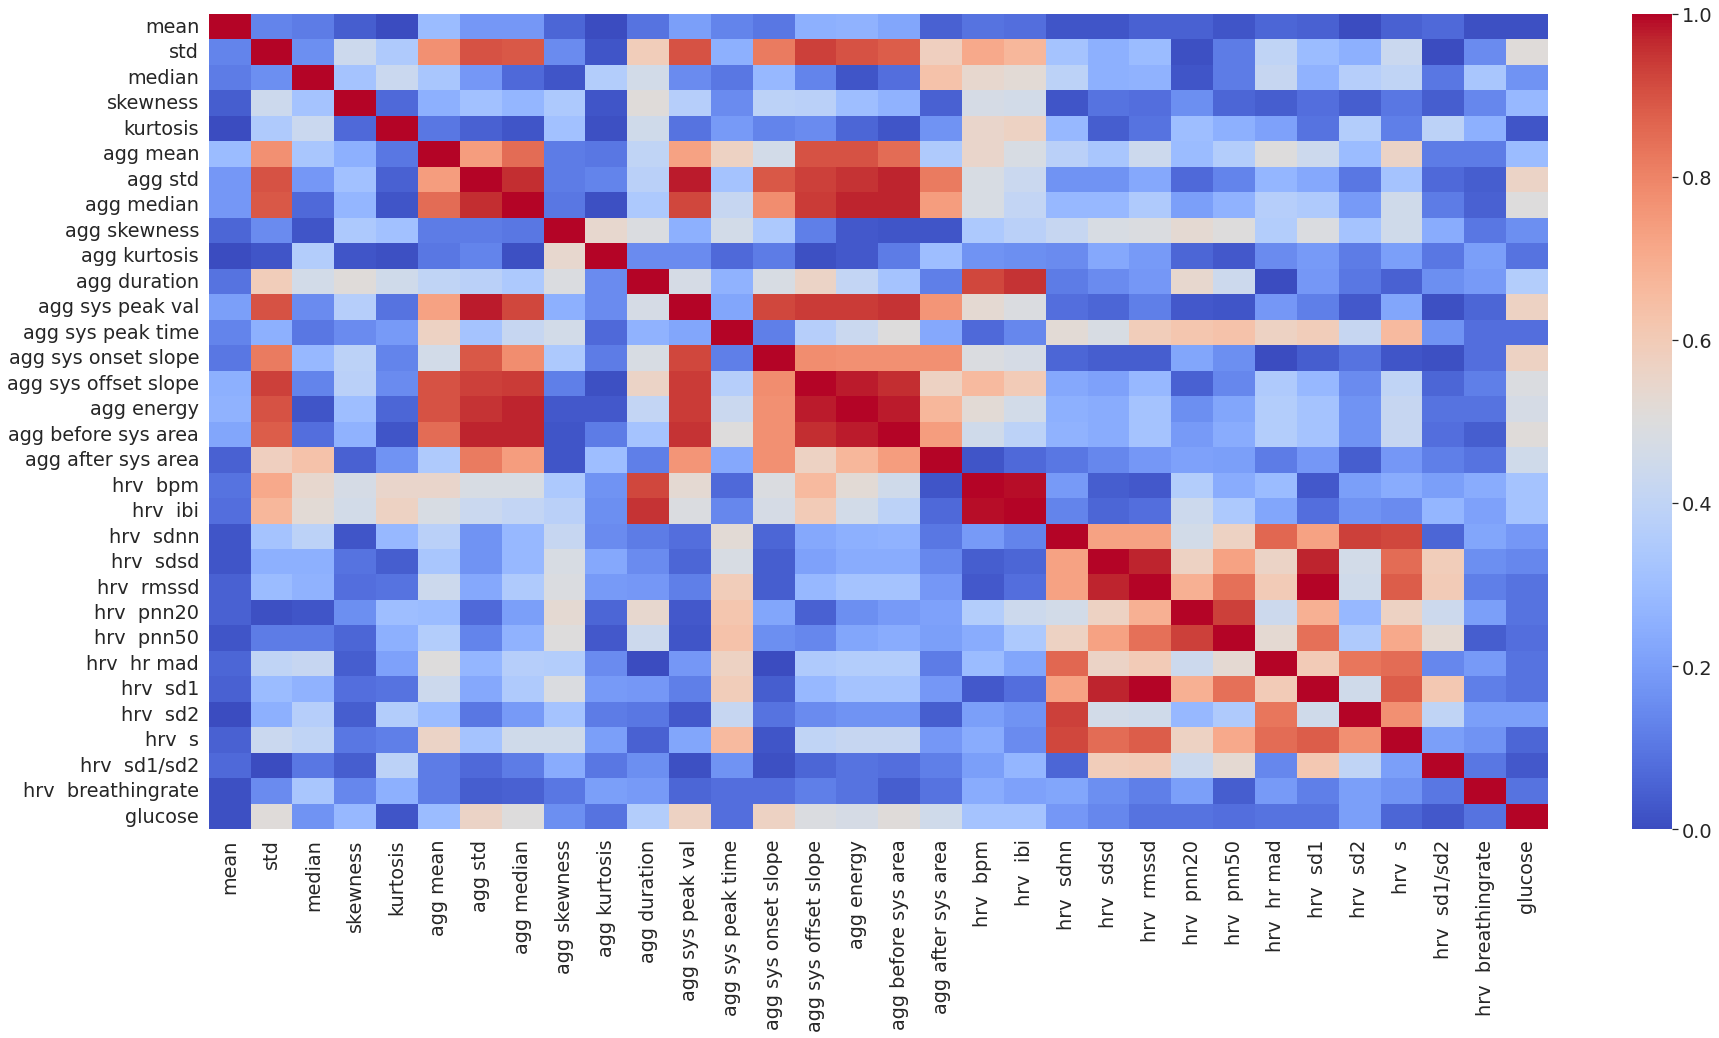

In [1532]:
corr = pd.DataFrame(abs(np.corrcoef(dff, rowvar=False)), columns=dff.columns, index=dff.columns)

sns.set(font_scale=1.75)
plt.figure(figsize=(30, 15))
sns.heatmap(corr.round(2), cmap='coolwarm', annot=False)
plt.savefig('feature_correlations.png', dpi=100, transparent=True, bbox_inches='tight')

# **Cross validation**

In [323]:
# sns.pairplot(df)

In [1398]:
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import mean_absolute_error

In [1593]:
X = df.drop('glucose', axis=1).values
y = df['glucose'].values

In [1594]:
model = RandomForestRegressor(n_estimators=300)

results = cross_validate(model, X, y, scoring='neg_mean_absolute_error', cv=20)

In [1431]:
abs(y - y.mean()).mean()

26.6888888888889

In [1595]:
-results['test_score'].mean(), results['test_score'].std()

(18.51961111111111, 17.58411272460821)

In [1402]:
results['test_score']

array([-12.63888889, -57.14861111, -24.21527778, -11.25111111,
        -8.21138889,  -7.4125    ,  -2.76444444,  -4.605     ,
       -44.16444444, -29.58527778])

# **Splitting by subjects**

In [27]:
df = pd.read_csv("dataset.csv").drop(['subject', 'session'], axis=1)
df = df.dropna()
df = df.astype({"hrv_features__sdsd": float}, errors='raise') 

In [1546]:
X = df.drop('glucose', axis=1).values
y = df['glucose'].values

Text(0.5, 1.0, 'MAE = 11.09')

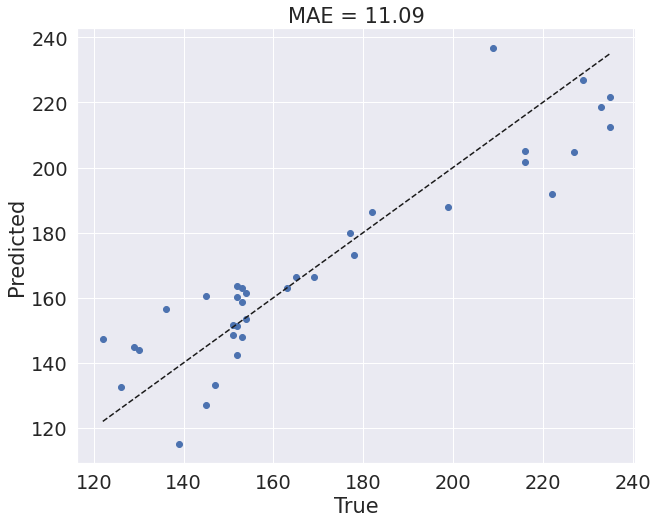

In [1625]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# n_samp = len(X) 
# train_size = 0.8
# last_train_idx = int(train_size*n_samp)
# X_train, X_test, y_train, y_test = X[:last_train_idx], X[last_train_idx:], y[:last_train_idx], y[last_train_idx:]

model = LGBMRegressor(n_estimators=300)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(y_test, y_pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
mae = mean_absolute_error(y_test, y_pred)
ax.set_xlabel("True")
ax.set_ylabel("Predicted")
ax.set_title(f"MAE = {mae:.2f}")